In [ ]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from PIL import Image
import os
import kagglehub
import shutil
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_curve, auc

### load data

In [ ]:
# Define the dataset you want to download
dataset_id = "paultimothymooney/breast-histopathology-images"
path = kagglehub.dataset_download(dataset_id)
print("Dataset downloaded to:", path)

# Specify the directory where you want to download the dataset
download_path = "/content/breast-histopathology-images"
os.makedirs(download_path, exist_ok=True)

# Download the dataset
for file in os.listdir(path):
    shutil.move(os.path.join(path, file), download_path)

print("Dataset downloaded to:", path)

100%|██████████| 3.10G/3.10G [00:20<00:00, 165MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1
Dataset downloaded to: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


In [ ]:
# Define the source and target directories
source_dir = "/content/breast-histopathology-images"
target_dir = "/content/breast-histopathology-images_flat"

# Create target directories for flat structure
positive_target = os.path.join(target_dir, "IDC_Positive")
negative_target = os.path.join(target_dir, "IDC_Negative")
os.makedirs(positive_target, exist_ok=True)
os.makedirs(negative_target, exist_ok=True)

# Walk through each patient folder and copy images into the flat structure.
for patient in os.listdir(source_dir):
    patient_path = os.path.join(source_dir, patient)
    if os.path.isdir(patient_path):
        # Check the two class subfolders "0" and "1"
        for class_folder in ["0", "1"]:
            class_path = os.path.join(patient_path, class_folder)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".png"):
                        source_file = os.path.join(class_path, file)
                        if class_folder == "0":
                            target_file = os.path.join(negative_target, file)
                        else:  # class_folder == "1"
                            target_file = os.path.join(positive_target, file)
                        shutil.copy2(source_file, target_file)

print("Dataset flattened successfully!")
print("IDC_Positive count:", len(os.listdir(positive_target)))
print("IDC_Negative count:", len(os.listdir(negative_target)))


Dataset flattened successfully!
IDC_Positive count: 78786
IDC_Negative count: 198738


### split data for training validation and test

In [ ]:
# Step 1: Gather file paths and labels
data_dir = "/content/breast-histopathology-images_flat"
classes = os.listdir(data_dir)  # Expected to be ['IDC_Negative', 'IDC_Positive']

all_samples = []
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    # Assign label: you can use 0 for IDC_Negative, 1 for IDC_Positive (or vice versa)
    label = 0 if cls.lower().startswith("idc_negative") else 1
    for file in os.listdir(cls_dir):
        if file.endswith(".png"):
            file_path = os.path.join(cls_dir, file)
            all_samples.append((file_path, label))

# Shuffle the list of samples
random.shuffle(all_samples)
dataset_size = len(all_samples)
print("Total samples:", dataset_size)


In [ ]:
# Step 2: Define split sizes (80% train, 10% validation, 10% test)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_samples = all_samples[:train_size]
val_samples = all_samples[train_size:train_size + val_size]
test_samples = all_samples[train_size + val_size:]

print("Total samples:", dataset_size)
print("Train samples:", len(train_samples))
print("Validation samples:", len(val_samples))
print("Test samples:", len(test_samples))

Total samples: 277524
Train samples: 166514
Validation samples: 55504
Test samples: 55506


In [ ]:
# Step 4: Define different transforms for training vs. validation/test
# Augmentation for training, basic for validation/test
# Augmentation for positive (cancer) samples
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Basic transform for negatives and for validation
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Step 3: Create a custom dataset class
class CustomHistopathologyDataset(Dataset):
    def __init__(self, samples, transform_pos=None, transform_neg=None):
        self.samples = samples
        self.transform_pos = transform_pos
        self.transform_neg = transform_neg

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = Image.open(file_path).convert("RGB")
        if label == 1 and self.transform_pos is not None:
            image = self.transform_pos(image)
        elif label == 0 and self.transform_neg is not None:
            image = self.transform_neg(image)
        return image, label

In [ ]:
train_dataset = CustomHistopathologyDataset(train_samples,
                                              transform_pos=augmented_transform,
                                              transform_neg=basic_transform)
val_dataset = CustomHistopathologyDataset(val_samples,
                                            transform_pos=basic_transform,
                                            transform_neg=basic_transform)
test_dataset = CustomHistopathologyDataset(test_samples,
                                             transform_pos=basic_transform,
                                             transform_neg=basic_transform)

# Calculate class frequencies in train_samples
class_counts = {}
for _, label in train_samples:
    class_counts[label] = class_counts.get(label, 0) + 1

# Assign weight for each sample: inverse of class frequency
weights = [1.0 / class_counts[label] for _, label in train_samples]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(train_samples), replacement=True)

BATCH = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# Check dataset sizes
print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

Train set size: 166514
Validation set size: 55504
Test set size: 55506


### Plot to check

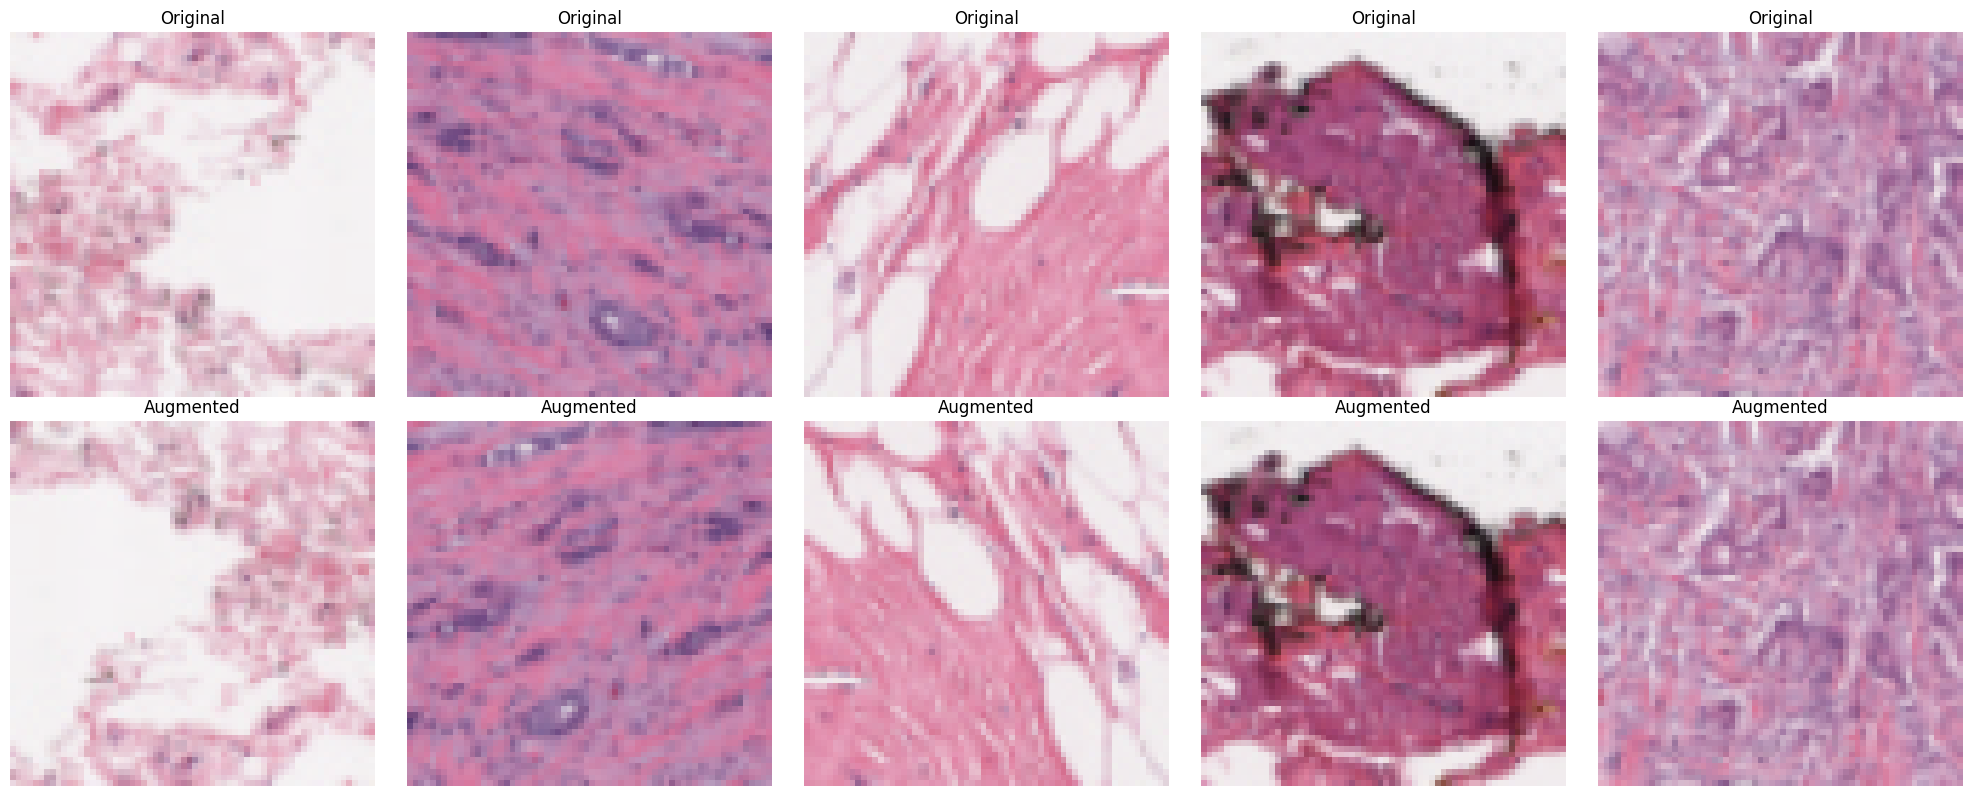

In [ ]:
# Randomly select 5 samples from the training samples list.
# (train_samples is a list of tuples: (file_path, label) that we created during splitting.)

# Unnormalize function to reverse ImageNet normalization
def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Make sure tensor is on CPU and detached
    tensor = tensor.cpu().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
selected_samples = random.sample(train_samples, 5)

original_images = []
augmented_images = []

for file_path, label in selected_samples:
    image = Image.open(file_path).convert("RGB")
    original_img = basic_transform(image)
    augmented_img = augmented_transform(image)
    original_img = unnormalize(original_img)
    augmented_img = unnormalize(augmented_img)
    original_np = original_img.numpy().transpose(1, 2, 0)
    augmented_np = augmented_img.numpy().transpose(1, 2, 0)
    original_images.append(original_np)
    augmented_images.append(augmented_np)

# Create a figure with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i in range(5):
    # Top row: Original images
    axs[0, i].imshow(original_images[i])
    axs[0, i].axis("off")
    axs[0, i].set_title("Original")

    # Bottom row: Augmented images
    axs[1, i].imshow(augmented_images[i])
    axs[1, i].axis("off")
    axs[1, i].set_title("Augmented")

plt.tight_layout()
plt.show()

In [ ]:
# Function for training the model
def train(model, train_loader, criterion, optimizer, device, accumulation_steps=1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass (no autocast, full precision)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps

        # Backward pass
        loss.backward()
        running_loss += loss.item() * accumulation_steps

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update weights every accumulation_steps batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    return epoch_loss, epoch_accuracy

# Function for validating the model
def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():  # No need to calculate gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels
            all_labels.append(labels.cpu())

            # Store predicted probabilities (assuming outputs is [batch_size, num_classes])
            # For binary classification, get probability of class=1 (e.g., outputs[:,1])
            probs = torch.softmax(outputs, dim=1)[:,1]  # shape [batch_size]
            all_probs.append(probs.cpu())

            all_preds.append(predicted.cpu())

    # Concatenate all labels and predictions
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = (correct / total) * 100

    # Compute F1 score (binary)
    val_f1 = f1_score(all_labels, all_preds)

    # Compute ROC AUC (binary)
    # all_probs are the predicted probabilities for class=1
    val_roc_auc = roc_auc_score(all_labels, all_probs)

    # Compute PR AUC (binary)
    val_pr_auc = average_precision_score(all_labels, all_probs)

    return epoch_loss, epoch_accuracy, val_f1, val_roc_auc, val_pr_auc

def test(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.append(labels.cpu())
            # Get probability for class=1 for binary classification
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.append(probs.cpu())
            all_preds.append(predicted.cpu())

    # Concatenate results
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    test_loss = running_loss / len(test_loader)
    test_accuracy = (correct / total) * 100

    # Calculate additional metrics
    test_f1 = f1_score(all_labels, all_preds)
    test_roc_auc = roc_auc_score(all_labels, all_probs)
    test_pr_auc = average_precision_score(all_labels, all_probs)

    return test_loss, test_accuracy, test_f1, test_roc_auc, test_pr_auc


In [ ]:
weight_decay = 0.01
num_epochs = 17

In [ ]:
# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
model.fc = new_classifier

# Optionally unfreeze the last layer/block if desired:
for param in model.layer4.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay=weight_decay)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

In [ ]:
print(type(model))

<class 'torchvision.models.resnet.ResNet'>


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/17
Train Loss: 0.3527, Train Accuracy: 85.03%
Validation Loss: 0.3486, Validation Accuracy: 85.32%
Validation F1: 0.7117, ROC AUC: 0.9012, PR AUC: 0.8069
Epoch 2/17
Train Loss: 0.3527, Train Accuracy: 85.01%
Validation Loss: 0.3484, Validation Accuracy: 85.53%
Validation F1: 0.7299, ROC AUC: 0.9024, PR AUC: 0.8076
Epoch 3/17
Train Loss: 0.3501, Train Accuracy: 85.10%
Validation Loss: 0.3475, Validation Accuracy: 85.38%
Validation F1: 0.7164, ROC AUC: 0.9014, PR AUC: 0.8067
Epoch 4/17
Train Loss: 0.3514, Train Accuracy: 85.07%
Validation Loss: 0.3482, Validation Accuracy: 85.34%
Validation F1: 0.7257, ROC AUC: 0.9018, PR AUC: 0.8077
Epoch 5/17
Train Loss: 0.3517, Train Accuracy: 85.13%
Validation Loss: 0.3469, Validation Accuracy: 85.46%
Validation F1: 0.7182, ROC AUC: 0.9014, PR AUC: 0.8066
Epoch 6/17
Train Loss: 0.3508, Train Accuracy: 85.10%
Validation Loss: 0.3487, Validation Accuracy: 85.37%
Validation F1: 0.7230, ROC AUC: 0.9018, PR AUC: 0.8070
Epoch 7/17
Train Loss: 0.346

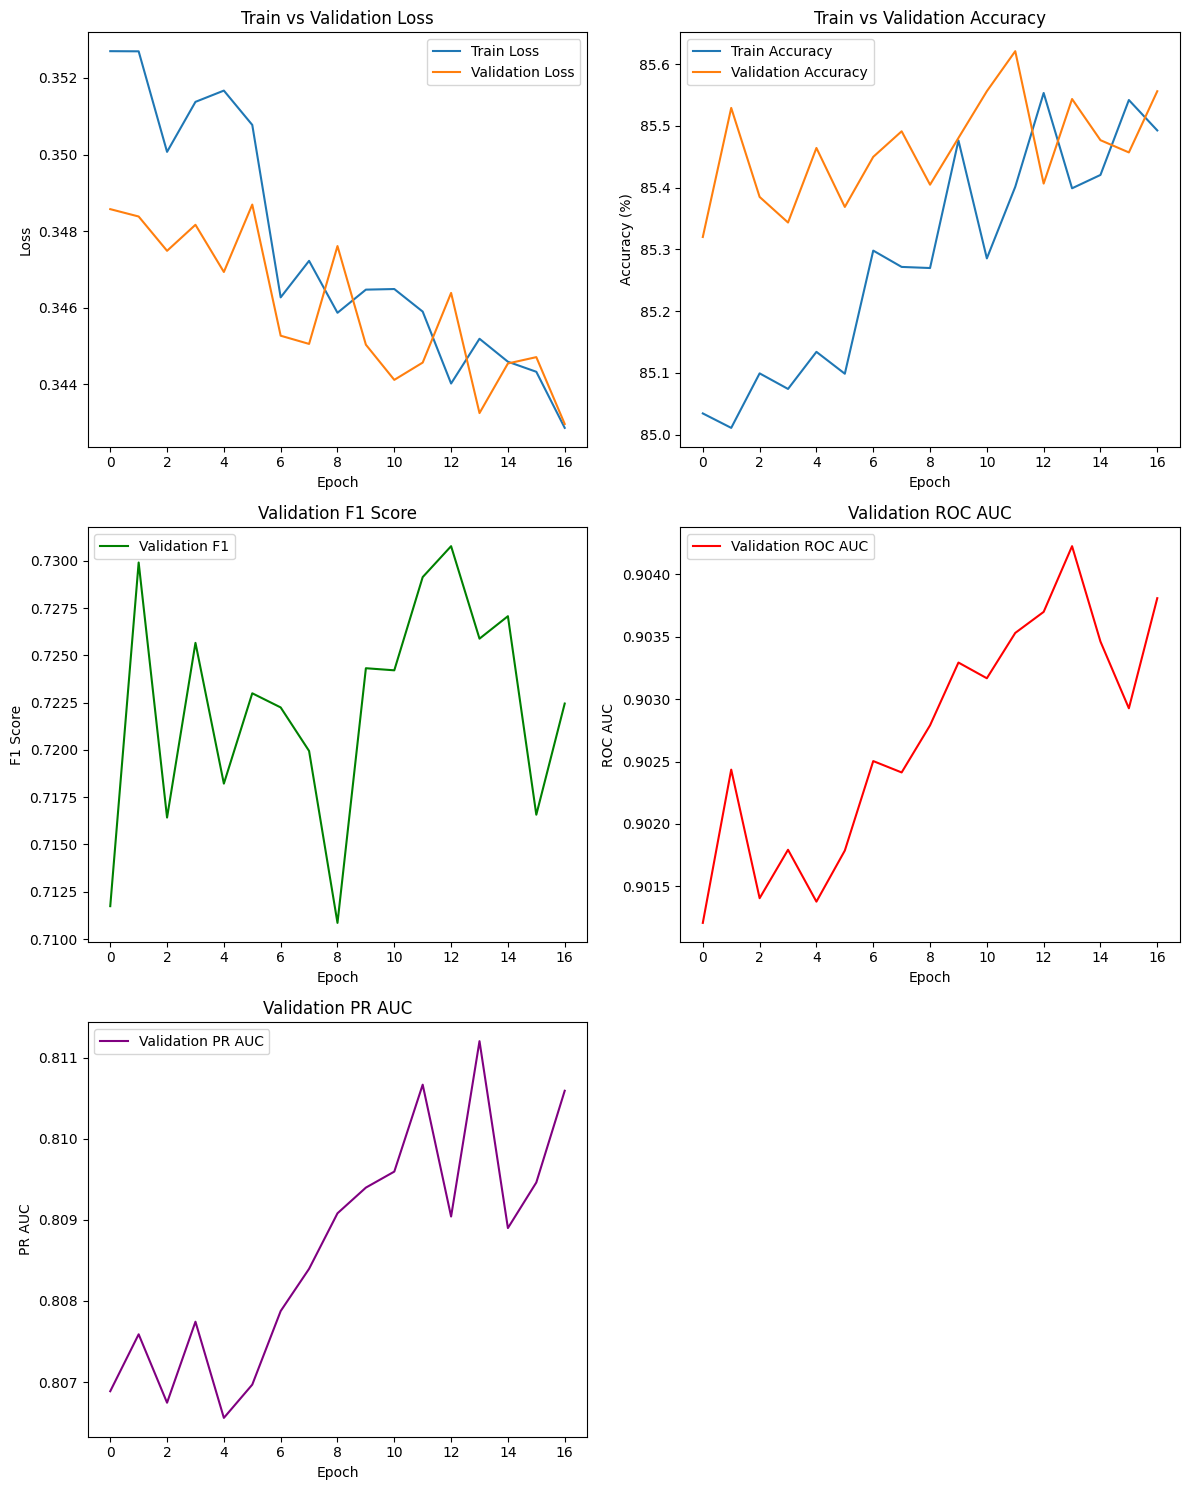

In [ ]:
# Check if a GPU is available and move the model to the appropriate device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# Initialize lists to store metrics
losses_train = []
losses_val = []
accs_val = []
accs_train = []
f1_scores = []
roc_auc_scores = []
pr_auc_scores = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    losses_train.append(train_loss)
    accs_train.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    val_loss, val_accuracy, val_f1, val_roc_auc, val_pr_auc = validate(model, val_loader, criterion, device)
    f1_scores.append(val_f1)
    roc_auc_scores.append(val_roc_auc)
    pr_auc_scores.append(val_pr_auc)
    losses_val.append(val_loss)
    accs_val.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation F1: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}, PR AUC: {val_pr_auc:.4f}")

    scheduler.step()

test_loss, test_accuracy, test_f1, test_roc_auc, test_pr_auc = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1: {test_f1:.4f}, Test ROC AUC: {test_roc_auc:.4f}, Test PR AUC: {test_pr_auc:.4f}")

# Plotting validation vs test metrics
epochs_arr = np.arange(num_epochs)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# Row 1: Loss and Accuracy
axes[0, 0].plot(epochs_arr, losses_train, label="Train Loss")
axes[0, 0].plot(epochs_arr, losses_val, label="Validation Loss")
axes[0, 0].set_title("Train vs Validation Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

axes[0, 1].plot(epochs_arr, accs_train, label="Train Accuracy")
axes[0, 1].plot(epochs_arr, accs_val, label="Validation Accuracy")
axes[0, 1].set_title("Train vs Validation Accuracy")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].legend()

# Row 2: F1 Score and ROC AUC
axes[1, 0].plot(epochs_arr, f1_scores, color='green', label="Validation F1")
axes[1, 0].set_title("Validation F1 Score")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("F1 Score")
axes[1, 0].legend()

axes[1, 1].plot(epochs_arr, roc_auc_scores, color='red', label="Validation ROC AUC")
axes[1, 1].set_title("Validation ROC AUC")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("ROC AUC")
axes[1, 1].legend()

# Row 3: PR AUC (and leave one subplot blank)
axes[2, 0].plot(epochs_arr, pr_auc_scores, color='purple', label="Validation PR AUC")
axes[2, 0].set_title("Validation PR AUC")
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("PR AUC")
axes[2, 0].legend()

# Hide the unused subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

### BUIILT BREAST CANCER CNN

Train set size: 166514
Validation set size: 55504
Test set size: 55506
Epoch 1/30 -- Train loss: 0.1433, Train acc: 0.9482, Val loss: 0.3513, Val acc: 0.8496
Epoch 2/30 -- Train loss: 0.1163, Train acc: 0.9537, Val loss: 0.3879, Val acc: 0.8412
Epoch 3/30 -- Train loss: 0.1093, Train acc: 0.9570, Val loss: 0.3756, Val acc: 0.8543
Epoch 4/30 -- Train loss: 0.1035, Train acc: 0.9592, Val loss: 0.3811, Val acc: 0.8543
Epoch 5/30 -- Train loss: 0.1028, Train acc: 0.9597, Val loss: 0.3348, Val acc: 0.8628
Epoch 6/30 -- Train loss: 0.0984, Train acc: 0.9619, Val loss: 0.3444, Val acc: 0.8430
Epoch 7/30 -- Train loss: 0.0955, Train acc: 0.9635, Val loss: 0.3370, Val acc: 0.8635
Epoch 8/30 -- Train loss: 0.0941, Train acc: 0.9639, Val loss: 0.3168, Val acc: 0.8680
Epoch 9/30 -- Train loss: 0.0917, Train acc: 0.9654, Val loss: 0.3388, Val acc: 0.8550
Epoch 10/30 -- Train loss: 0.0881, Train acc: 0.9667, Val loss: 0.3078, Val acc: 0.8668
Epoch 11/30 -- Train loss: 0.0873, Train acc: 0.9669, Val 

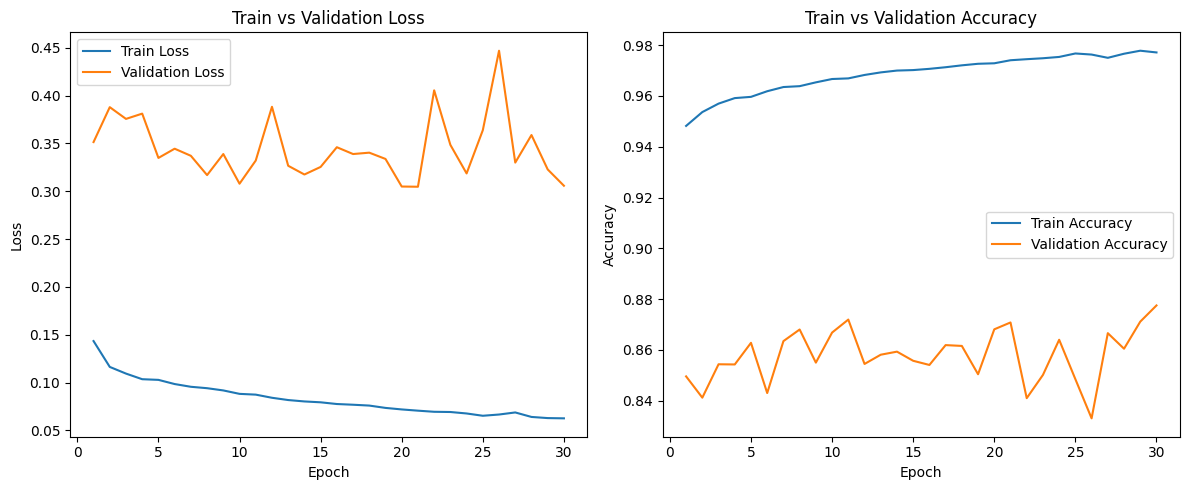

In [ ]:
import os
import shutil
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

# ------------------------------------------------------------
# 1. Define the CNN Model
# ------------------------------------------------------------
class BreastCancerCNN(nn.Module):
    def __init__(self):
        super(BreastCancerCNN, self).__init__()
        # Convolutional blocks
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2   = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layers
        # Input image size is 50x50. After two pooling layers: 50->25->12 (approx)
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 64)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 24)
        self.fc5 = nn.Linear(24, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.bn2(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x  # raw logits; use CrossEntropyLoss which applies softmax internally

# ------------------------------------------------------------
# 2. Define your Custom Dataset Class
# ------------------------------------------------------------
class CustomHistopathologyDataset(Dataset):
    def __init__(self, samples, transform_pos=None, transform_neg=None):
        """
        samples: list of tuples (file_path, label)
        transform_pos: transformation for positive class (IDC positive)
        transform_neg: transformation for negative class (IDC negative)
        """
        self.samples = samples
        self.transform_pos = transform_pos
        self.transform_neg = transform_neg

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = Image.open(file_path).convert("RGB")
        # Apply a different transform based on the label if desired.
        if label == 1 and self.transform_pos is not None:
            image = self.transform_pos(image)
        elif label == 0 and self.transform_neg is not None:
            image = self.transform_neg(image)
        else:
            # Default transform if none provided
            image = transforms.ToTensor()(image)
        return image, label

# ------------------------------------------------------------
# 3. Define Transformations
# ------------------------------------------------------------
# Example transformations: you can customize these.
basic_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    # Optionally, add normalization:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# ------------------------------------------------------------
# 4. Create your Dataset Splits
# ------------------------------------------------------------
# Assume you have defined lists: train_samples, val_samples, test_samples.
# Each should be a list of tuples: (file_path, label)

# For example purposes, here are dummy lists.
# In your real code, these would come from scanning your flattened directories.
# Example:
# train_samples = [(<path_to_image1>, 0), (<path_to_image2>, 1), ...]
# val_samples = [...]
# test_samples = [...]

# For demonstration, let’s say you already have these variables defined.
# train_samples, val_samples, test_samples = ...

# ------------------------------------------------------------
# 5. Create Dataset Instances and DataLoaders
# ------------------------------------------------------------
train_dataset = CustomHistopathologyDataset(train_samples,
                                              transform_pos=augmented_transform,
                                              transform_neg=basic_transform)
val_dataset = CustomHistopathologyDataset(val_samples,
                                            transform_pos=basic_transform,
                                            transform_neg=basic_transform)
test_dataset = CustomHistopathologyDataset(test_samples,
                                             transform_pos=basic_transform,
                                             transform_neg=basic_transform)

# If you want to use a WeightedRandomSampler for handling class imbalance:
class_counts = {}
for _, label in train_samples:
    class_counts[label] = class_counts.get(label, 0) + 1

weights = [1.0 / class_counts[label] for _, label in train_samples]
sampler = WeightedRandomSampler(weights, num_samples=len(train_samples), replacement=True)

BATCH = 64
# You can pass the sampler in place of shuffle if you want balanced batches
train_loader = DataLoader(train_dataset, batch_size=BATCH, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

# ------------------------------------------------------------
# 6. Instantiate the Model, Optimizer, and Loss Function
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BreastCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# ------------------------------------------------------------
# 7. Training Loop
# ------------------------------------------------------------
num_epochs = 30

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # raw logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} -- Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# ------------------------------------------------------------
# 8. Evaluate on the Test Set
# ------------------------------------------------------------
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / total_test
test_acc = correct_test / total_test

print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Optionally, save the trained model:
torch.save(model.state_dict(), "BreastCancerCNN.pth")

# ------------------------------------------------------------
# 9. Plotting Train vs Validation Metrics
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

epochs_arr = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(epochs_arr, train_losses, label="Train Loss")
plt.plot(epochs_arr, val_losses, label="Validation Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_arr, train_accuracies, label="Train Accuracy")
plt.plot(epochs_arr, val_accuracies, label="Validation Accuracy")
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#pip install git+https://github.com/Mahmoodlab/CONCH.git

  Cloning https://github.com/Mahmoodlab/CONCH.git to /tmp/pip-req-build-581md2c8
  Running command git clone --filter=blob:none --quiet https://github.com/Mahmoodlab/CONCH.git /tmp/pip-req-build-581md2c8
  Resolved https://github.com/Mahmoodlab/CONCH.git to commit 171f2be94d8871fa9af72de6b86685c135333ee8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for conch: filename=conch-0.1.0-py3-none-any.whl size=413301 sha256=f2a4bc1038f6398ec53c7117583f566c4fa1ced99c655c605ea689505439244a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxkrk2rq/wheels/0a/27/73/38d1a8400ebd14c51a6eb306f672fdabbcf789fa25f66723b3
Successfully built conch


### CONCH

In [ ]:
from getpass import getpass
from conch.open_clip_custom import create_model_from_pretrained

hf_token = getpass("Enter your Hugging Face token: ")

model, preprocess = create_model_from_pretrained(
    'conch_ViT-B-16',
    "hf_hub:MahmoodLab/conch",
    hf_auth_token=hf_token
)

meta.yaml:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/conch/open_clip_custom/factory.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_loca

In [ ]:
weight_decay = 0.01
num_epochs = 17

In [ ]:
for param in model.parameters():
    param.requires_grad = False

new_classifier = nn.Sequential(
    nn.Linear(512, 256),
    nn.GELU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)

# Create a classifier model that uses the Conch image encoder.
class ConchClassifier(nn.Module):
    def __init__(self, base_model, classifier):
        super(ConchClassifier, self).__init__()
        self.base_model = base_model   # Pretrained model
        self.classifier = classifier   # New classification head

    def forward(self, image):
        # image: a batch of preprocessed images.
        features = self.base_model.encode_image(image)
        logits = self.classifier(features)
        return logits

model_classifier = ConchClassifier(model, new_classifier)

# Optionally unfreeze the last transformer block of the Conch model to fine-tune it.
if hasattr(model, "transformer"):
    for param in model.transformer.layers[-1].parameters():
        param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_classifier = model_classifier.to(device)

criterion = nn.CrossEntropyLoss()

# We set up the optimizer to update the classifier head parameters
# and optionally the last transformer block (if unfrozen).
params_to_opt = list(model_classifier.classifier.parameters())
if hasattr(model, "transformer"):
    params_to_opt += list(model.transformer.layers[-1].parameters())

optimizer = optim.AdamW(params_to_opt, lr=1e-3, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

In [ ]:
def train(model, train_loader, criterion, optimizer, device, accumulation_steps=1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()
        running_loss += loss.item() * accumulation_steps

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    return epoch_loss, epoch_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.append(labels.cpu())
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.append(probs.cpu())
            all_preds.append(predicted.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = (correct / total) * 100

    val_f1 = f1_score(all_labels, all_preds)
    val_roc_auc = roc_auc_score(all_labels, all_probs)
    val_pr_auc = average_precision_score(all_labels, all_probs)

    return epoch_loss, epoch_accuracy, val_f1, val_roc_auc, val_pr_auc

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.append(labels.cpu())
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.append(probs.cpu())
            all_preds.append(predicted.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    test_loss = running_loss / len(test_loader)
    test_accuracy = (correct / total) * 100
    test_f1 = f1_score(all_labels, all_preds)
    test_roc_auc = roc_auc_score(all_labels, all_probs)
    test_pr_auc = average_precision_score(all_labels, all_probs)

    # Ensure we return seven values.
    return test_loss, test_accuracy, test_f1, test_roc_auc, test_pr_auc, all_labels, all_probs


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and get training metrics.
    train_loss, train_acc = train(model_classifier, train_loader, criterion, optimizer, device)
    print(f"Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validate and get validation metrics.
    val_loss, val_acc, val_f1, val_roc_auc, val_pr_auc = validate(model_classifier, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")
    print(f"Validation F1: {val_f1:.4f} | ROC AUC: {val_roc_auc:.4f} | PR AUC: {val_pr_auc:.4f}")

    scheduler.step()

# Optionally, run testing after training
test_loss, test_acc, test_f1, test_roc_auc, test_pr_auc = test(model_classifier, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%, "
      f"Test F1: {test_f1:.4f}, Test ROC AUC: {test_roc_auc:.4f}, Test PR AUC: {test_pr_auc:.4f}")

Epoch 1/17
Train loss: 0.2877 | Train Accuracy: 87.76%
Validation Loss: 0.2798 | Validation Accuracy: 88.02%
Validation F1: 0.7819 | ROC AUC: 0.9384 | PR AUC: 0.8672
Epoch 2/17
Train loss: 0.2847 | Train Accuracy: 87.90%
Validation Loss: 0.2868 | Validation Accuracy: 87.75%
Validation F1: 0.7910 | ROC AUC: 0.9393 | PR AUC: 0.8690
Epoch 3/17
Train loss: 0.2828 | Train Accuracy: 87.99%
Validation Loss: 0.2750 | Validation Accuracy: 88.25%
Validation F1: 0.7848 | ROC AUC: 0.9406 | PR AUC: 0.8708
Epoch 4/17
Train loss: 0.2809 | Train Accuracy: 88.12%
Validation Loss: 0.2752 | Validation Accuracy: 88.21%
Validation F1: 0.7823 | ROC AUC: 0.9407 | PR AUC: 0.8707
Epoch 5/17
Train loss: 0.2795 | Train Accuracy: 88.16%
Validation Loss: 0.2747 | Validation Accuracy: 88.12%
Validation F1: 0.7846 | ROC AUC: 0.9408 | PR AUC: 0.8710
Epoch 6/17
Train loss: 0.2791 | Train Accuracy: 88.17%
Validation Loss: 0.2734 | Validation Accuracy: 88.29%
Validation F1: 0.7815 | ROC AUC: 0.9415 | PR AUC: 0.8726
Epoc

Epoch 1/17
Train loss: 0.2659 | Train Accuracy: 88.77%
Validation Loss: 0.2641 | Validation Accuracy: 88.75%
Validation F1: 0.7953 | ROC AUC: 0.9453 | PR AUC: 0.8812
Epoch 2/17
Train loss: 0.2658 | Train Accuracy: 88.83%
Validation Loss: 0.2641 | Validation Accuracy: 88.75%
Validation F1: 0.7956 | ROC AUC: 0.9453 | PR AUC: 0.8812
Epoch 3/17
Train loss: 0.2654 | Train Accuracy: 88.83%
Validation Loss: 0.2638 | Validation Accuracy: 88.74%
Validation F1: 0.7917 | ROC AUC: 0.9455 | PR AUC: 0.8814
Epoch 4/17
Train loss: 0.2656 | Train Accuracy: 88.79%
Validation Loss: 0.2637 | Validation Accuracy: 88.78%
Validation F1: 0.7958 | ROC AUC: 0.9454 | PR AUC: 0.8814
Epoch 5/17
Train loss: 0.2657 | Train Accuracy: 88.80%
Validation Loss: 0.2637 | Validation Accuracy: 88.73%
Validation F1: 0.7931 | ROC AUC: 0.9454 | PR AUC: 0.8814
Epoch 6/17
Train loss: 0.2652 | Train Accuracy: 88.80%
Validation Loss: 0.2637 | Validation Accuracy: 88.79%
Validation F1: 0.7960 | ROC AUC: 0.9455 | PR AUC: 0.8814
Epoc

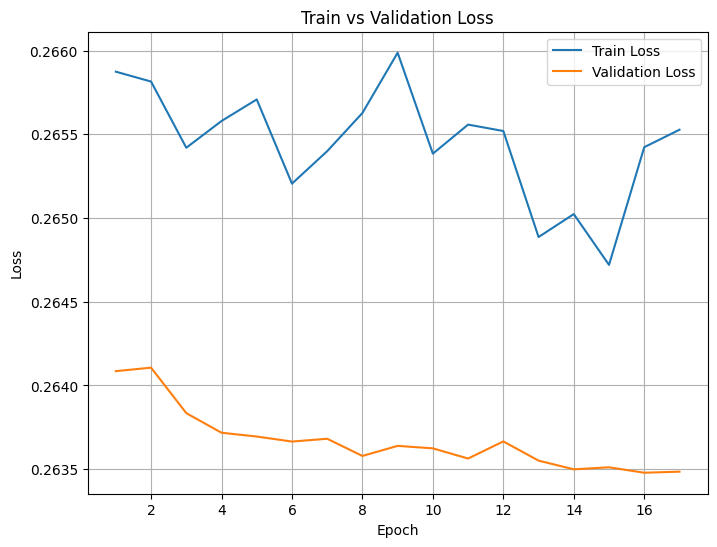

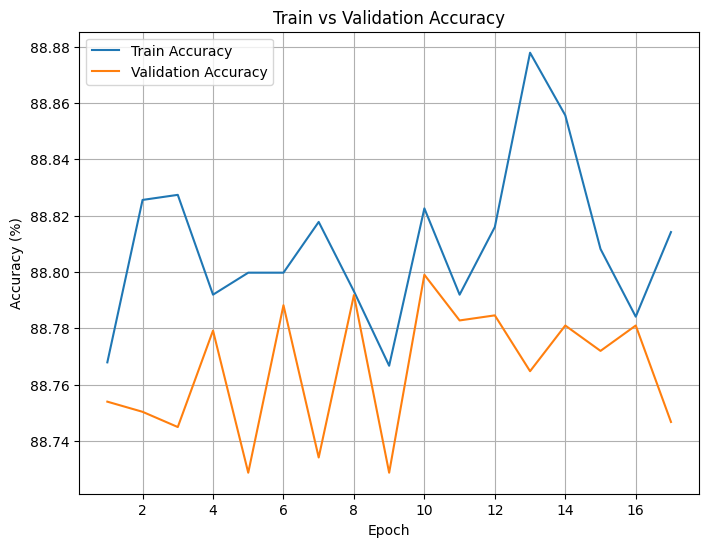

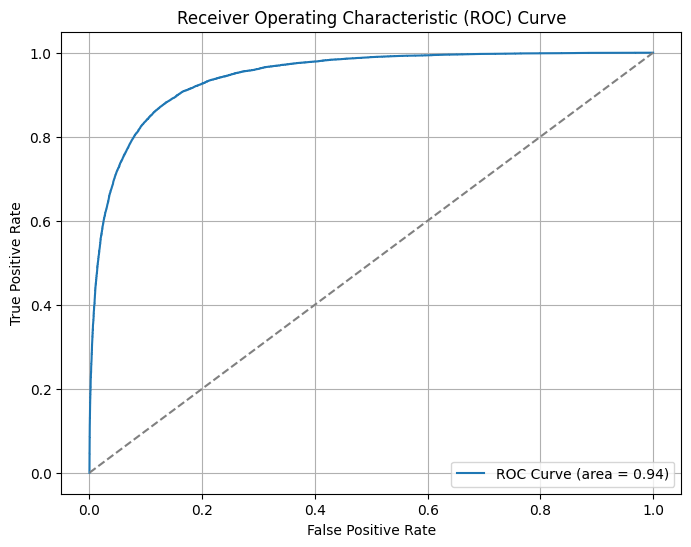

In [ ]:
train_losses_list = []
train_accs_list = []
val_losses_list = []
val_accs_list = []
val_f1s_list = []
val_roc_aucs_list = []
val_pr_aucs_list = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train and record training metrics.
    train_loss, train_acc = train(model_classifier, train_loader, criterion, optimizer, device)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_acc)
    print(f"Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validate and record validation metrics.
    val_loss, val_acc, val_f1, val_roc_auc, val_pr_auc = validate(model_classifier, val_loader, criterion, device)
    val_losses_list.append(val_loss)
    val_accs_list.append(val_acc)
    val_f1s_list.append(val_f1)
    val_roc_aucs_list.append(val_roc_auc)
    val_pr_aucs_list.append(val_pr_auc)

    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")
    print(f"Validation F1: {val_f1:.4f} | ROC AUC: {val_roc_auc:.4f} | PR AUC: {val_pr_auc:.4f}")

    scheduler.step()

# Run testing after training and also retrieve all test labels and probabilities for ROC.
test_loss, test_acc, test_f1, test_roc_auc, test_pr_auc, test_labels, test_probs = test(model_classifier, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
print(f"Test F1: {test_f1:.4f}, Test ROC AUC: {test_roc_auc:.4f}, Test PR AUC: {test_pr_auc:.4f}")

# Plot Train vs Validation Loss
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses_list, label='Train Loss')
plt.plot(epochs, val_losses_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Train vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accs_list, label='Train Accuracy')
plt.plot(epochs, val_accs_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Compute and plot ROC Curve using test set predictions.
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

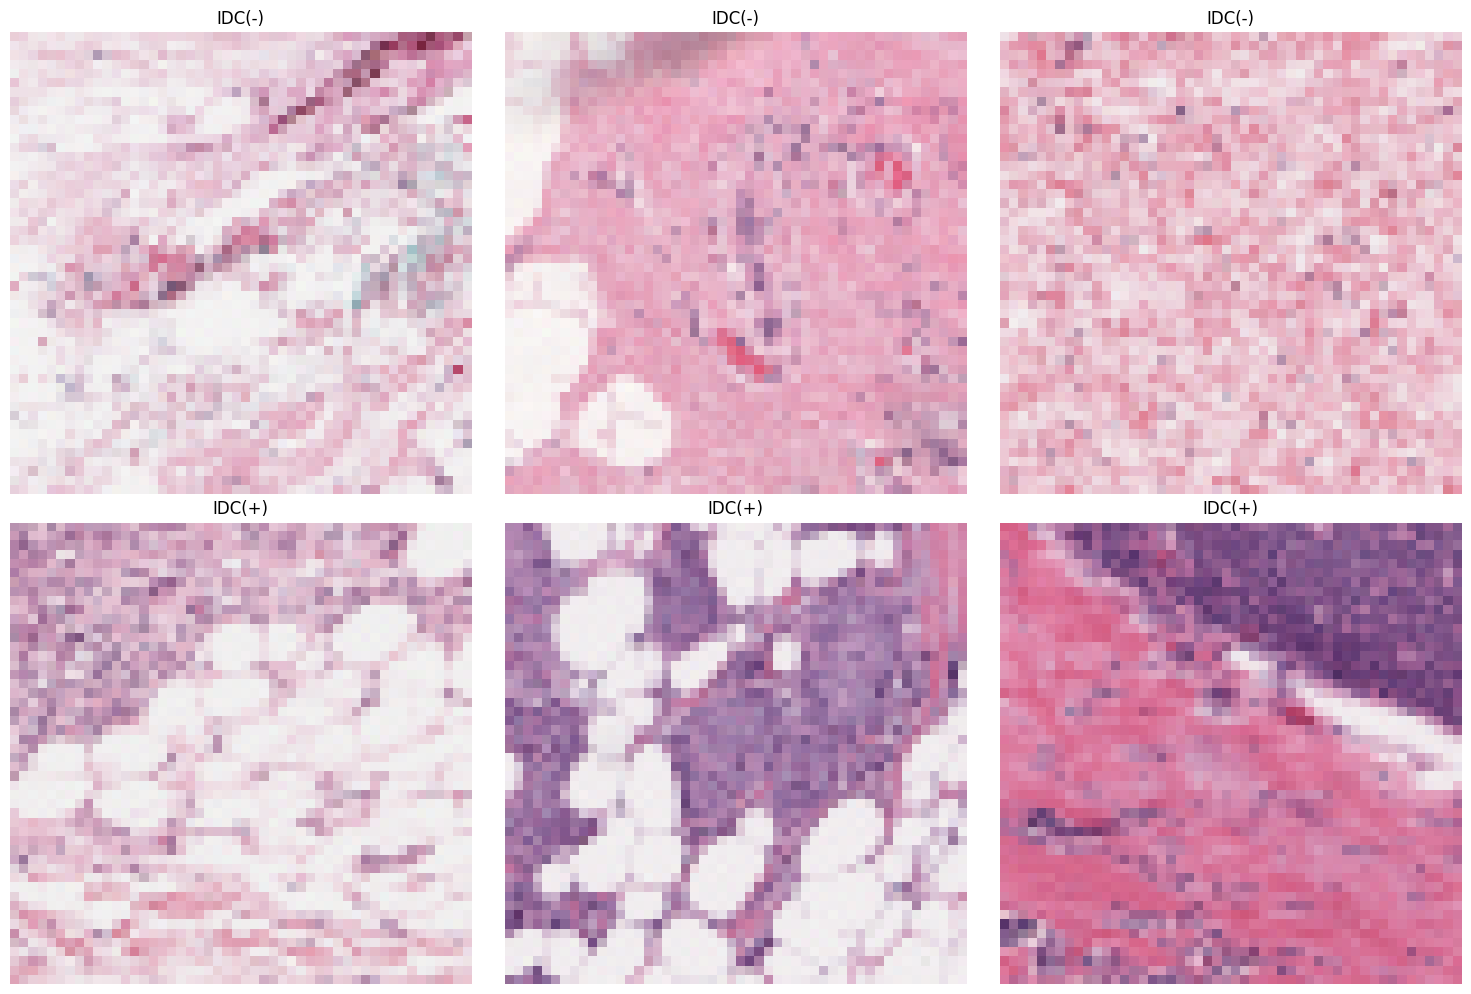

In [ ]:
# Define directories for each class
negative_dir = "/content/breast-histopathology-images_flat/IDC_Negative"
positive_dir = "/content/breast-histopathology-images_flat/IDC_Positive"

# Get list of image file paths for each class
neg_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if f.endswith(".png")]
pos_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if f.endswith(".png")]

# Randomly select 3 images from each class
selected_neg = random.sample(neg_files, 3)
selected_pos = random.sample(pos_files, 3)

# Create a 2-row by 3-column plot: first row for negative, second row for positive
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot IDC-negative images
for i, file in enumerate(selected_neg):
    img = Image.open(file)
    axes[0, i].imshow(img)
    axes[0, i].set_title("IDC(-)")
    axes[0, i].axis("off")

# Plot IDC-positive images
for i, file in enumerate(selected_pos):
    img = Image.open(file)
    axes[1, i].imshow(img)
    axes[1, i].set_title("IDC(+)")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()